In [1]:
from icalendar import Calendar
from datetime import datetime
from icalendar.prop import vText, vDDDTypes, vCalAddress

import pandas as pd

CALENDAR_EXPLORT_FIlE_NAME = 'sitesh@tiqets.com.ics'

g = open(CALENDAR_EXPLORT_FIlE_NAME, 'rb')
gcal = Calendar.from_ical(g.read())

meetings = []
for component in gcal.walk():
    if component.name == 'VEVENT':        
        meetings.append([
            
            str(vText.from_ical(component.get('summary'))),
            str(vText.from_ical(component.get('description'))),
            
            vCalAddress.from_ical(component.get('organizer')).split('mailto:')[-1],
            [vCalAddress.from_ical(x).split('mailto:')[-1] for x in (component.get('attendee') or [])],
            
            str(vText.from_ical(component.get('location'))),
            str(vText.from_ical(component.get('status'))),
            
            vDDDTypes.from_ical(component.get('dtstart')),
            vDDDTypes.from_ical(component.get('dtend')),
            vDDDTypes.from_ical(component.get('created')),
            vDDDTypes.from_ical(component.get('last-modified'))
        ])
g.close()
columns = ['summary',  'description',  'organizer',  'attendee',  'location', 'status',  'dtstart', 'dtend', 'created', 'last-modified']

df = pd.DataFrame(meetings, columns=columns)

df.head()

,summary,description,organizer,attendee,location,status,dtstart,dtend,created,last-modified
0,Introduction,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,marijn@tiqets.com,"[sitesh@tiqets.com, marijn@tiqets.com, tiqets....",HQ-4-Lunchroom-Room 'Amsterdam' (6),CONFIRMED,2018-07-16 11:00:00+00:00,2018-07-16 12:00:00+00:00,2018-07-16 08:19:37+00:00,2018-07-16 11:10:02+00:00
1,Intro Perf.marketing,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,anita@tiqets.com,"[sitesh@tiqets.com, yuri@tiqets.com, tiqets.co...",HQ-4-tech side-Room 'Paris' (6) [Screen],CONFIRMED,2018-07-20 11:00:00+00:00,2018-07-20 12:00:00+00:00,2018-07-17 09:02:34+00:00,2018-07-18 09:02:37+00:00
2,Discuss w/Patrick,,None,[],,CONFIRMED,2018-07-18 11:00:00+00:00,2018-07-18 12:00:00+00:00,2018-07-18 09:59:04+00:00,2018-07-18 10:50:12+00:00
3,High Level System Architecture,,sitesh@tiqets.com,"[sitesh@tiqets.com, tjerk@tiqets.com, tiqets.c...",HQ-4-Lunchroom-Room 'Amsterdam' (6),CONFIRMED,2018-07-18 14:30:00+00:00,2018-07-18 15:30:00+00:00,2018-07-18 09:59:22+00:00,2018-07-18 14:56:34+00:00
4,Intro Content,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,sitesh@tiqets.com,"[sandra@tiqets.com, sitesh@tiqets.com, yuri@ti...",HQ-4-tech side-Room 'Rome' (6),CONFIRMED,2018-07-19 09:15:00+00:00,2018-07-19 10:00:00+00:00,2018-07-17 09:17:19+00:00,2018-07-19 07:55:49+00:00


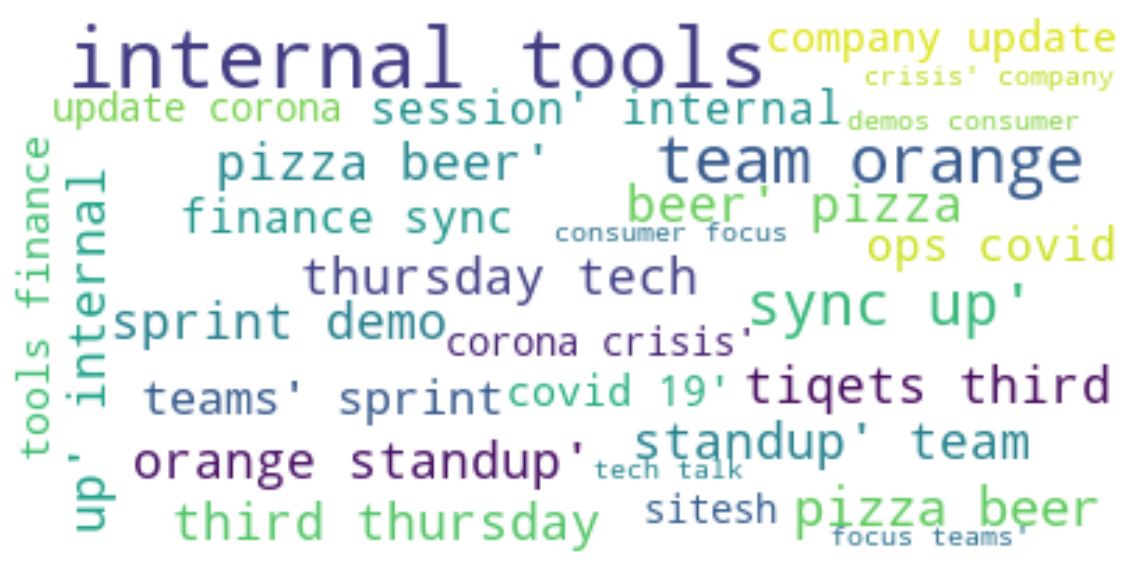

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud of meeting titles

summary_wordcloud = WordCloud(
    background_color='white', 
    stopwords=None,
    include_numbers=True, 
#     max_words=50,
    min_font_size=10, 
    max_font_size=30
).generate_from_text(str(df.summary.values).capitalize())

plt.figure(figsize=(20,20))
plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

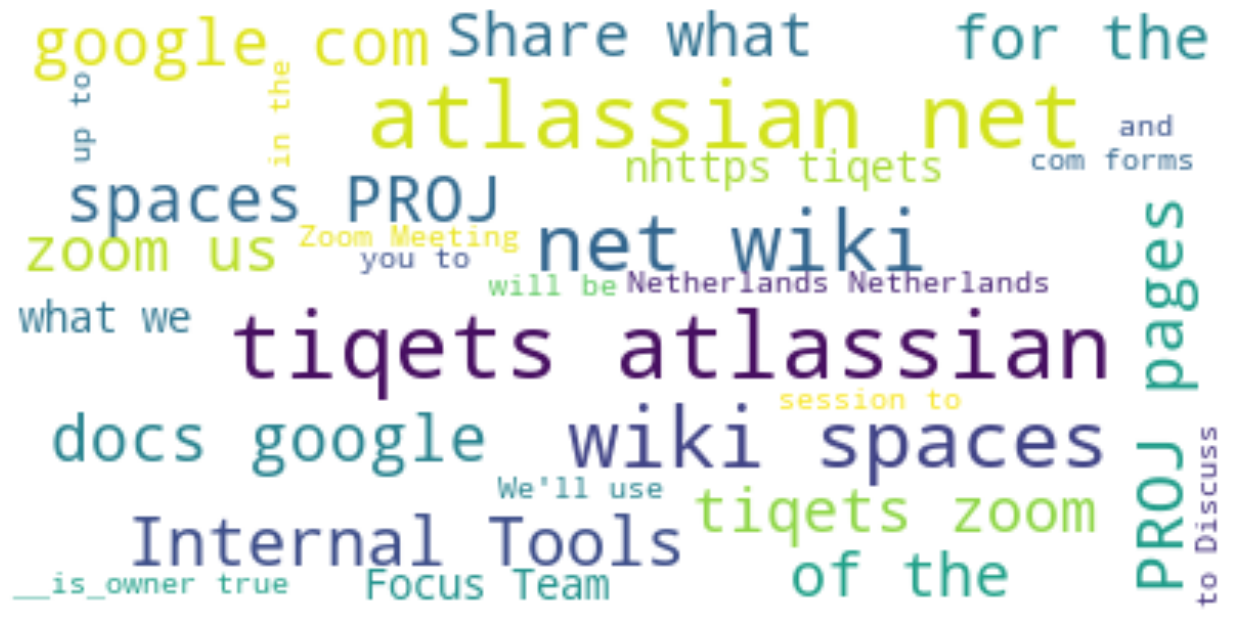

In [3]:
# Generate word cloud of meeting details

description_wordcloud = WordCloud(
    background_color='white', 
    stopwords=['http', 'https', 'nbsp', 'br', 'li', 'href', 'src'],
#     include_numbers=True, 
    max_words=50,
    min_font_size=10, 
    max_font_size=30
).generate_from_text(str(df.description.str.rsplit('-::~:~::~:~:').str.get(0).tolist()))

plt.figure(figsize=(22,22))
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='# Meeting attendees', ylabel='% Meetings (by count)'>

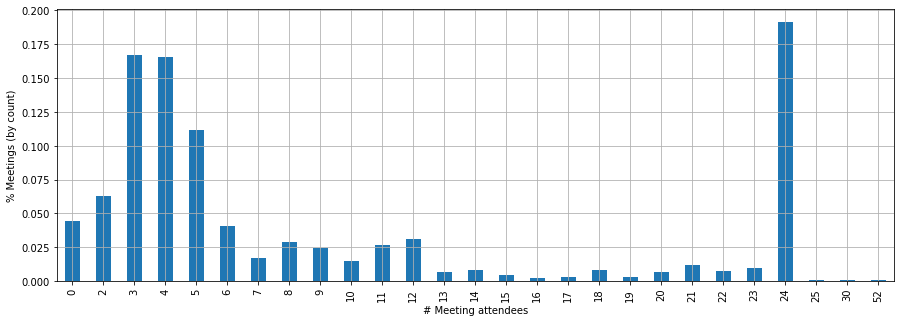

In [4]:
# Plot number of meetings over number of participants
from pandas import PeriodIndex
import numpy as np

df['attendee_count'] = df.attendee.apply(len)
df['attendee_count'].value_counts(sort=False, normalize=True).plot(
    kind='bar', 
    grid=True, 
    xlabel='# Meeting attendees', 
    ylabel='% Meetings (by count)',
    figsize=(15,5)
)

<AxesSubplot:xlabel='Meeting duration (minutes)', ylabel='% Meetings (by time)'>

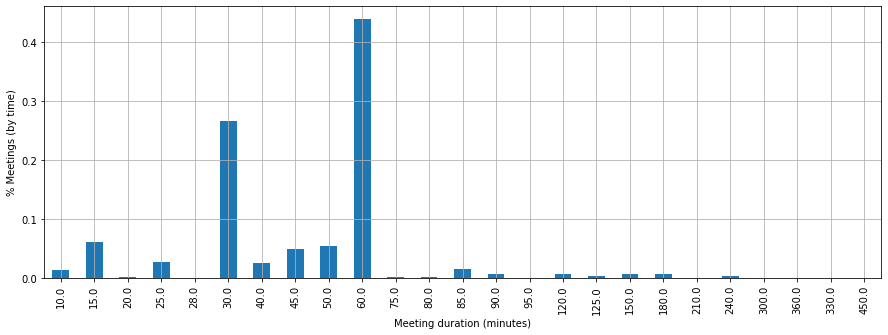

In [5]:
# Plot time spent in meetings over number of participants

df['meeting_duration'] = (df['dtend'] - df['dtstart']).astype('timedelta64[m]')

df[df['meeting_duration'] < 8 * 60].dropna()['meeting_duration'].sort_values().value_counts(sort=False, normalize=True).plot(
    kind='bar', 
    grid=True, 
    xlabel='Meeting duration (minutes)', 
    ylabel='% Meetings (by time)',
    figsize=(15, 5)
)


In [6]:
# Plot number of meetings & time spent over time


<AxesSubplot:xlabel='Meeting location', ylabel='% Meetings (by count)'>

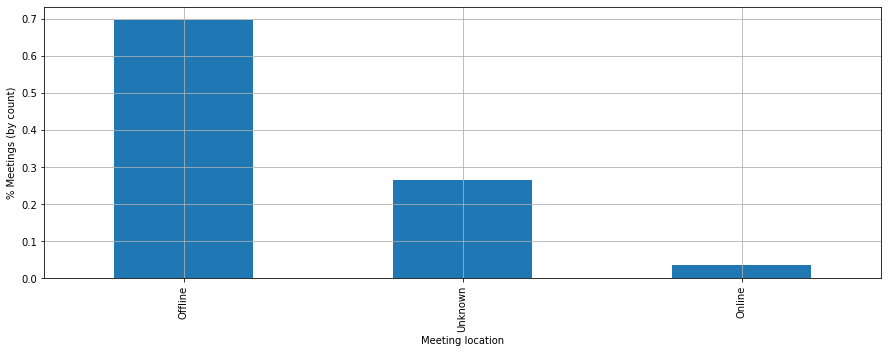

In [7]:
# Plot number of online : offline meetings

def get_location(location):
    if 'http' in location:
        return 'Online'
    elif location:
        return 'Offline'
    else:
        return 'Unknown'

df['meeting_location'] = df['location'].apply(lambda location: get_location(location.strip()))

df['meeting_location'].value_counts(normalize=True).plot(
    kind='bar', 
    grid=True,
    ylabel='% Meetings (by count)',
    xlabel='Meeting location',
    figsize=(15,5)
)

<AxesSubplot:xlabel='Meeting location', ylabel='% Meetings (by time)'>

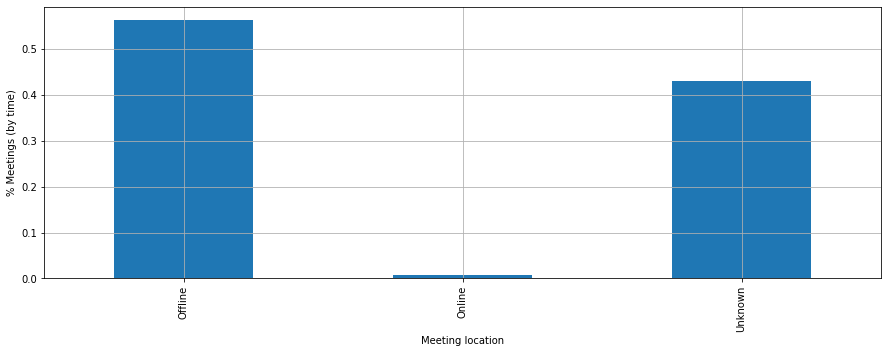

In [8]:
# Plot time spent in online : offline meetings

(df.groupby(['meeting_location'])['meeting_duration'].sum() / df['meeting_duration'].sum()).plot(
    kind='bar', 
    grid=True,
    ylabel='% Meetings (by time)', 
    xlabel='Meeting location',
    figsize=(15,5)
)

In [9]:
# Plot total ratio of online : offline meetings over time


<AxesSubplot:ylabel='Meeting organizer'>

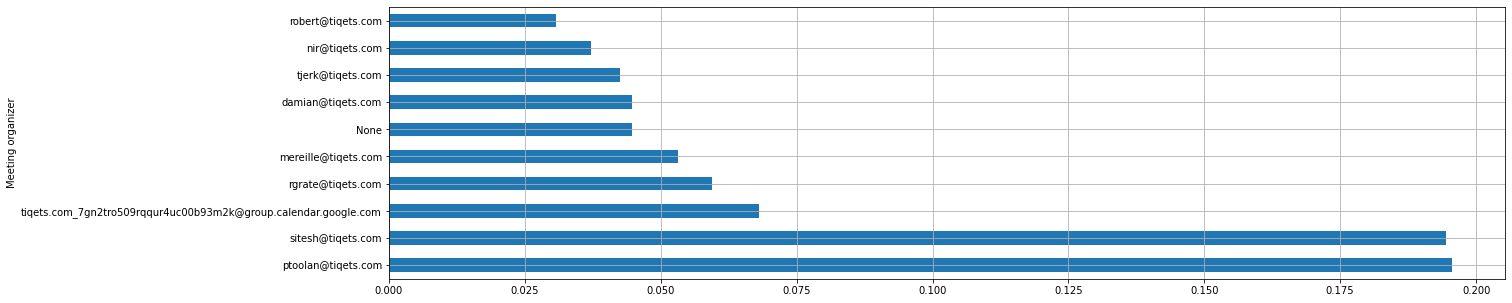

In [10]:
# Plot top 10 meeting organizers by count

df['organizer'].value_counts(normalize=True)[:10].plot(
    kind='barh', 
    grid=True,
    ylabel='% Meetings (by count)', 
    xlabel='Meeting organizer',
    figsize=(20,5)
)

<AxesSubplot:ylabel='Meeting attendee'>

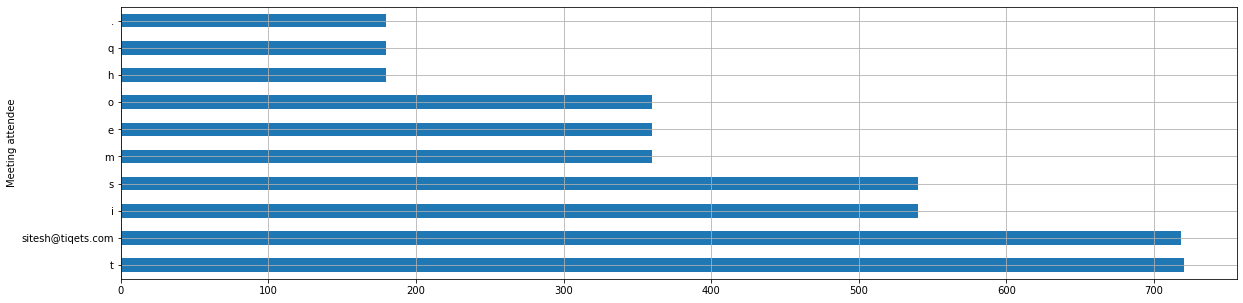

In [11]:
# Plot top meeting participants by number

df.explode('attendee', ignore_index=True)['attendee'].value_counts()[:10].plot(
    kind='barh', 
    grid=True,
    ylabel='% Meetings (by count)', 
    xlabel='Meeting attendee',
    figsize=(20,5)
)
